In [1]:
# import libraries
import sys 
sys.path.append('..')
from model.neural_adjoint_map import *
from model.optimizer import *
from methods.linear_ref import *
from methods.nam_ref import *
import matplotlib.pyplot as plt


In [2]:
#load data
import yaml
import sys
sys.path.append('./../../NRP/Unsupervised-Learning-of-Robust-Spectral-Shape-Matching/')
import logging
from os import path as osp

from datasets import build_dataset
from models import build_model

import yaml
from utils.tensor_util import to_device,to_numpy
import torch
import numpy as np

#torch.cuda.set_device(0)

#pointcloud

DATASET='dt4d_interclass'

with open('./../../NRP/Unsupervised-Learning-of-Robust-Spectral-Shape-Matching/options/test/'+DATASET+'.yaml', 'r') as f:
    opt = yaml.load(f, Loader=yaml.SafeLoader)
opt['is_train']=False
test_set = build_dataset(opt['datasets']['test_dataset'])

shape1=test_set[3]['first']
shape2=test_set[3]['second']
mass1=torch.diag(shape1['mass'])
mass2=torch.diag(shape1['mass'])

# LB eigenfunctions

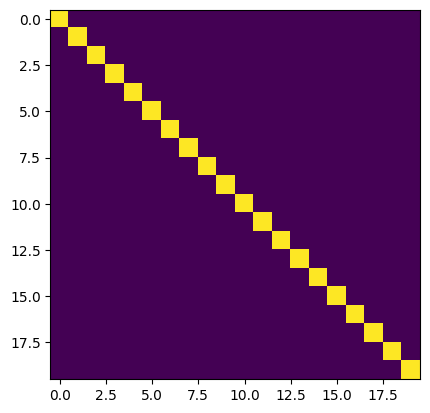

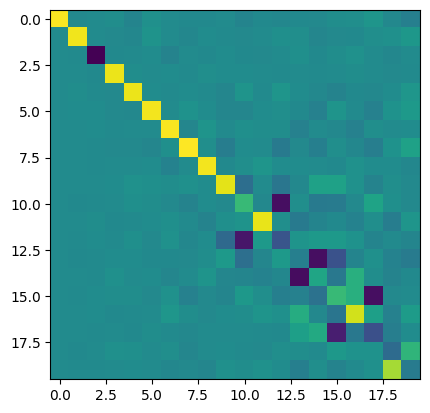

In [3]:
#lbo basis
basis1=shape1['evecs']
basis2=shape2['evecs']

mass1_sp=basis1.T@mass1@basis1
plt.imshow(mass1_sp[:20,:20])
plt.show()
fmap=torch.linalg.pinv(basis1[shape1['corr']][:,:20])@basis2[shape2['corr'],:20]
plt.imshow(fmap)

In [4]:

test_set = build_dataset(opt['datasets']['test_dataset'])
opt['is_train'] = False
model = build_model(opt)
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize variables
n_exp = 5
n_k = len(range(20, 201, 20)) + 1
mse_nzo = np.zeros((n_exp, n_k))
g_nzo = np.zeros((n_exp, n_k))

#ind=np.random.randint(0,len(test_set),n_exp)
ind=np.arange(n_exp)

results = {}

zo_l = []
abzo_l =[]

mzo_l = []
mabzo_l = []

nzo_l=[]
mnzo_l=[]


import h5py

for i in ind:
    data_x, data_y = to_device(test_set[i]['second'], device), to_device(test_set[i]['first'], device)
    if data_x['name'] != data_y['name']:
        dist_y = data_y['dist'].cpu()
        corr_x = data_x['corr']
        corr_y = data_y['corr']
        dist_y = to_numpy(dist_y)
        corr_x = to_numpy(corr_x)
        corr_y = to_numpy(corr_y)
        #C = torch.linalg.pinv(data_y['evecs'][corr_y, :20]) @ data_x['evecs'][corr_x, :20]
        #p2p_ini = nearest(data_x['evecs'][:, :20], data_y['evecs'][:, :20] @ C).cpu().numpy()
        with h5py.File('/home/ubuntu/NRP//NRP/nfr/results/mesh/'+DATASET+'/results.h5', 'r+') as hf:
            p2p_ini=hf[f'unsup_noref_{i}'][:]
        mass1=torch.diag(data_x['mass'])
        mass1_sp=data_x['evecs'].T@mass1@data_x['evecs']
        mass2=torch.diag(data_y['mass'])
        mass2_sp=data_y['evecs'].T@mass2@data_y['evecs']

        p2p=zoomout(data_x['evecs'],data_y['evecs'],p2p_ini,20,201,20).cpu()
        zo_l.append(model.metrics['geo_error'](dist_y, corr_y, corr_x, p2p, return_mean=False).mean().item())
        p2p=zoomout_mass(data_x['evecs'],data_y['evecs'],p2p_ini,20,201,20,mass1_sp,mass2_sp).cpu()
        mzo_l.append(model.metrics['geo_error'](dist_y, corr_y, corr_x, p2p, return_mean=False).mean().item())
        
        p2p=ab_zoomout(data_x['evecs'],data_y['evecs'],p2p_ini,20,201,20).cpu()
        abzo_l.append(model.metrics['geo_error'](dist_y, corr_y, corr_x, p2p, return_mean=False).mean().item())
        p2p=abzo_mass(data_x['evecs'],data_y['evecs'],p2p_ini,20,201,20,mass1_sp,mass2_sp).cpu()
        mabzo_l.append(model.metrics['geo_error'](dist_y, corr_y, corr_x, p2p, return_mean=False).mean().item())

        p2p=neural_zoomout(data_x['evecs'],data_y['evecs'],p2p_ini,20,201,20).cpu()
        nzo_l.append(model.metrics['geo_error'](dist_y, corr_y, corr_x, p2p, return_mean=False).mean().item())
        p2p=neural_zoomout_mass(data_x['evecs'],data_y['evecs'],p2p_ini,20,201,20,mass1_sp,mass2_sp).cpu()
        mnzo_l.append(model.metrics['geo_error'](dist_y, corr_y, corr_x, p2p, return_mean=False).mean().item())


    i=i+1
    print(i)
print('zo:',np.mean(zo_l))
print('zo mass:',np.mean(mzo_l))

print('abzo:',np.mean(abzo_l))
print('abzo mass:',np.mean(mabzo_l))

print('nzo:',np.mean(nzo_l))
print('nzo mass:',np.mean(mnzo_l))



torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
1
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
2
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
3
torch.float32
torch.float32
torch.float32
torch.complex64


RuntimeError: expected mat1 and mat2 to have the same dtype, but got: float != c10::complex<float>

In [7]:
mass_inv_sqrt=torch.tensor(scipy.linalg.sqrtm(torch.linalg.inv((mass1_sp[:80,:80])).cpu().numpy())).to('cuda')
print(mass_inv_sqrt)

tensor([[ 1.0000e+00+0.0000e+00j,  2.5486e-08-1.7596e-17j,
          2.1993e-08-2.2254e-18j,  ...,
          1.7377e-09-2.3040e-17j, -2.7052e-09+6.8716e-18j,
          5.3792e-09-1.0507e-18j],
        [ 3.3643e-08+0.0000e+00j,  1.0000e+00-3.3996e-10j,
          5.9881e-08-2.1822e-11j,  ...,
         -5.4808e-08-3.4982e-10j, -3.6975e-08+1.8218e-10j,
         -3.6575e-08-4.9958e-11j],
        [ 1.1539e-08+0.0000e+00j,  6.6179e-08-1.9914e-10j,
          1.0000e+00-2.0437e-11j,  ...,
          2.6550e-08-3.3495e-10j,  5.3872e-08+9.0777e-11j,
          4.6862e-08-2.2795e-11j],
        ...,
        [-4.1694e-10+0.0000e+00j, -3.5541e-08-6.5573e-10j,
          3.9886e-08+3.1590e-11j,  ...,
          1.0000e+00-7.3469e-10j, -2.1926e-08+2.8387e-10j,
          1.2447e-08-6.3390e-11j],
        [-3.9410e-09+0.0000e+00j, -3.0706e-08+1.7632e-10j,
          3.9847e-08+9.1113e-12j,  ...,
         -2.8373e-08+2.3375e-10j,  1.0000e+00-9.0051e-11j,
          5.2697e-08+2.5039e-11j],
        [ 1.9521e-09+0

In [ ]:
print(mass1_sp[,:200].dtype)
mass_inv_sqrt=torch.tensor(scipy.linalg.sqrtm(torch.linalg.inv((mass1_sp[:20,:20])).cpu().numpy()))
print(mass_inv_sqrt.dtype)


torch.float32
torch.float32


# Elastic basis

In [38]:

test_set = build_dataset(opt['datasets']['test_dataset'])
opt['is_train'] = False
model = build_model(opt)
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize variables
n_exp = 5
n_k = len(range(20, 201, 20)) + 1
mse_nzo = np.zeros((n_exp, n_k))
g_nzo = np.zeros((n_exp, n_k))

#ind=np.random.randint(0,len(test_set),n_exp)
ind=np.arange(n_exp)

results = {}

zo_l = []
abzo_l =[]
ima_l = []
fsf_l = []
nzo_l=[]
mnzo_l=[]
mzo_l = []
mima_l = []
mfsf_l = []
mabzo_l = []

import h5py

for i in ind:
    data_x, data_y = to_device(test_set[i]['second'], device), to_device(test_set[i]['first'], device)
    if data_x['name'] != data_y['name']:
        dist_y = data_y['dist'].cpu()
        corr_x = data_x['corr']
        corr_y = data_y['corr']
        dist_y = to_numpy(dist_y)
        corr_x = to_numpy(corr_x)
        corr_y = to_numpy(corr_y)
        #C = torch.linalg.pinv(data_y['evecs'][corr_y, :20]) @ data_x['evecs'][corr_x, :20]
        #p2p_ini = nearest(data_x['evecs'][:, :20], data_y['evecs'][:, :20] @ C).cpu().numpy()
        with h5py.File('/home/ubuntu/NRP//NRP/nfr/results/mesh/'+DATASET+'/results.h5', 'r+') as hf:
            p2p_ini=hf[f'unsup_noref_{i}'][:]
        with h5py.File('/home/ubuntu/NRP/ElasticBasisForSpectralMatching/basis/'+DATASET+'/'+data_x['name']+'.h5', 'r') as f:
            data_x['elastic']=torch.tensor(np.array(f['elastic']))[:,:200].to(device)
        with h5py.File('/home/ubuntu/NRP/ElasticBasisForSpectralMatching/basis/'+DATASET+'/'+data_y['name']+'.h5', 'r') as f:
            data_y['elastic']=torch.tensor(np.array(f['elastic']))[:,:200].to(device)
        mass1=torch.diag(data_x['mass'])
        mass1_sp=data_x['elastic'].T@mass1@data_x['elastic']
        
        mass2=torch.diag(data_y['mass'])
        mass2_sp=data_y['elastic'].T@mass2@data_y['elastic']

        
        p2p=abzo(data_x['elastic'],data_y['elastic'],p2p_ini,20,201,20).cpu()
        abzo_l.append(model.metrics['geo_error'](dist_y, corr_y, corr_x, p2p, return_mean=False).mean().item())
        p2p=abzo_mass(data_x['elastic'],data_y['elastic'],p2p_ini,20,201,20,mass1_sp,mass2_sp).cpu()
        mabzo_l.append(model.metrics['geo_error'](dist_y, corr_y, corr_x, p2p, return_mean=False).mean().item())
        


        p2p=zoomout(data_x['elastic'],data_y['elastic'],p2p_ini,20,201,20).cpu()
        zo_l.append(model.metrics['geo_error'](dist_y, corr_y, corr_x, p2p, return_mean=False).mean().item())
        p2p=zoomout_mass(data_x['elastic'],data_y['elastic'],p2p_ini,20,201,20,mass1_sp,mass2_sp).cpu()
        mzo_l.append(model.metrics['geo_error'](dist_y, corr_y, corr_x, p2p, return_mean=False).mean().item())
        
        p2p=neural_zoomout(data_x['elastic'],data_y['elastic'],p2p_ini,20,201,20).cpu()
        nzo_l.append(model.metrics['geo_error'](dist_y, corr_y, corr_x, p2p, return_mean=False).mean().item())
        p2p=neural_zoomout_mass(data_x['elastic'],data_y['elastic'],p2p_ini,20,201,20,mass1_sp,mass2_sp).cpu()
        mnzo_l.append(model.metrics['geo_error'](dist_y, corr_y, corr_x, p2p, return_mean=False).mean().item())


    i=i+1
    print(i)
print('zo:',np.mean(zo_l))
print('zo mass:',np.mean(mzo_l))

print('abzo:',np.mean(abzo_l))
print('abzo mass:',np.mean(mabzo_l))

print('nzo:',np.mean(nzo_l))
print('nzo mass:',np.mean(mnzo_l))



1
2
3
4
5
zo: 0.09963404685258866
zo mass: 0.07170272246003151
abzo: 0.10253393352031707
abzo mass: 0.08925248682498932
nzo: 0.04714714288711548
nzo mass: 0.045884739607572556
